## Práctico 3 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
connection_string = "DefaultEndpointsProtocol=https;AccountName=lucianagerman4638471639;AccountKey=s3ctA9+X+SqyzvUbgzESug9elvK5YbHEKD7Px4RuFu5SG/34BuO5zl+AkbffpYG1q8J+LSbjnpqp+AStfiXepA==;EndpointSuffix=core.windows.net"
container_name = "azureml-blobstore-712d0730-8ebc-42ee-99e3-a783cdcdbbff"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [3]:
blob_list = container_client.list_blobs() 

def load_image(blob):

    blob_client = blob_service_client.get_blob_client(container_name, blob.name)
    blob_data = blob_client.download_blob().readall()
    image = tf.image.decode_image(blob_data)
    image = tf.image.resize(image, (32, 32)) 
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    label = blob.name.split("_")[1].split(".")[0]
    return image, label

images = []

for blob in [blob for blob in blob_list if blob.name.startswith('images')]:
        image, label = load_image(blob)
        images.append((image, label))
    
images = np.array(images)


2023-06-30 03:38:11.829681: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-30 03:38:11.907194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2023-06-30 03:38:12.012617: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-30 03:38:12.868400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-30 03:38:13.256517: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-30 03:38:13.413946: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

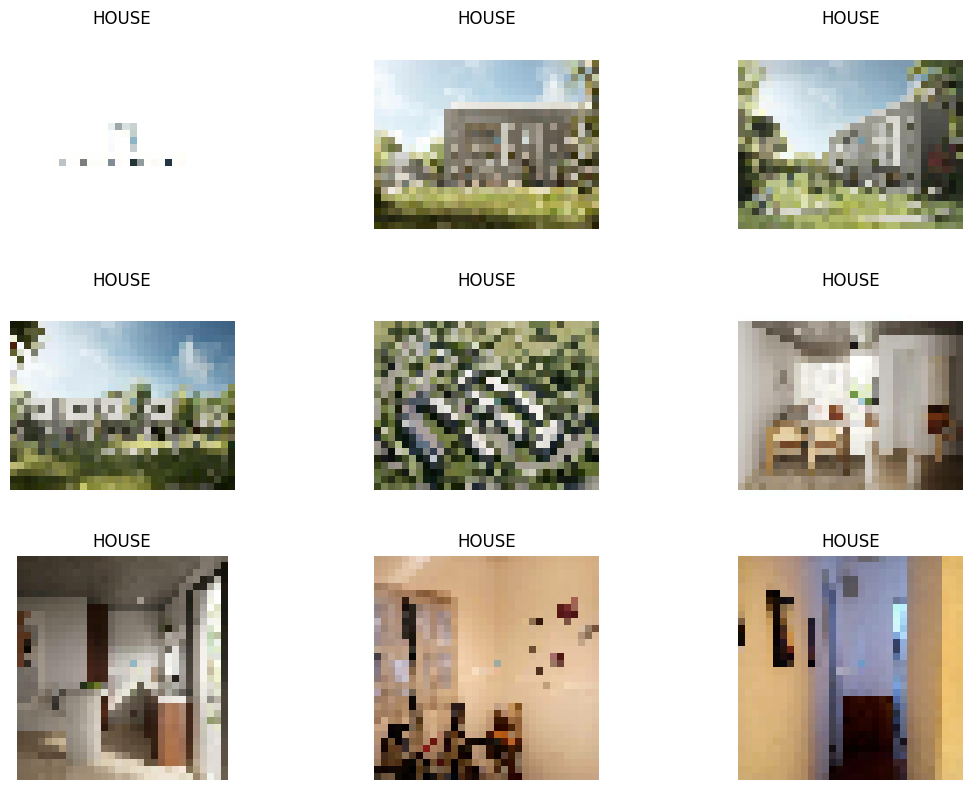

In [4]:
# Función para visualizar imágenes de muestra y sus etiquetas
def plot_sample_images(x, y):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.clip(x[i], 0, 1))
        plt.title(y[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar imágenes de muestra y sus etiquetas
plot_sample_images([tupla[0] for tupla in images], [tupla[1] for tupla in images])

In [5]:
# Dividir el objeto Dataset en conjuntos de entrenamiento y prueba
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

x_train=np.array([image[0] for image in images_train])
y_train=np.array([label[1] for label in images_train])

x_test=np.array([image[0] for image in images_test])
y_test=np.array([label[1] for label in images_test])

binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.fit_transform(y_test)

# Convertir las etiquetas en one-hot
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)


In [6]:
type(x_train)

numpy.ndarray

In [124]:
# Define tu modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

# Compila y entrena el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=10, validation_data=(x_test, y_test))
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2023-06-30 03:36:02.621733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-30 03:36:23.039683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.2.4 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-06-30 03:36:23.040549: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.
2023-06-30 03:36:23.040603: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device

UnimplementedError: Graph execution error:

Detected at node 'sequential_8/conv2d_32/Relu' defined at (most recent call last):
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5355/2523707309.py", line 28, in <module>
      history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_8/conv2d_32/Relu'
DNN library is not found.
	 [[{{node sequential_8/conv2d_32/Relu}}]] [Op:__inference_train_function_49278]

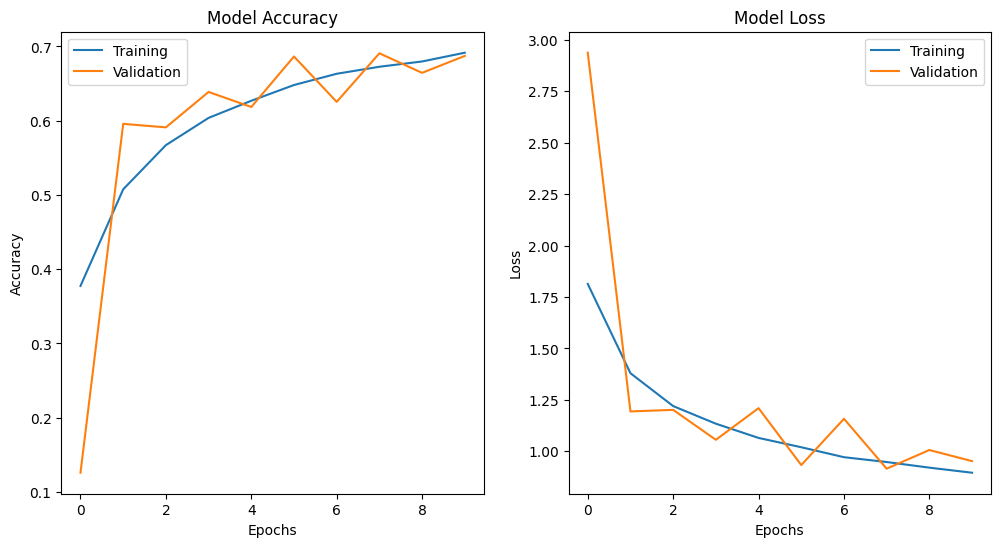

In [15]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training')
    plt.plot(history_df['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training')
    plt.plot(history_df['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('training_validation_plots.png')
    plt.show()

# Call the plotting function to display the graphs
plot_history(history)

# Save the trained model
model.save('conv.h5')